In [1]:
import warnings
warnings.filterwarnings("ignore")

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.distributed import DistributedSampler
import torch
import torch.distributed as dist
import torch.nn as nn
import functools
#from echo.src.base_objective import BaseObjective

from collections import defaultdict
from argparse import ArgumentParser
from pathlib import Path

import pandas as pd
import numpy as np
import subprocess
import torch.fft
import logging
import shutil
import random

# import optuna
# import wandb
import tqdm
import glob
import os
import gc
import sys
import yaml

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed.checkpoint as DCP
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
from torch.distributed.fsdp.sharded_grad_scaler import ShardedGradScaler
from torch.distributed.fsdp.fully_sharded_data_parallel import (
    CPUOffload,
    BackwardPrefetch,
)
from torch.distributed.fsdp.wrap import (
    size_based_auto_wrap_policy,
    enable_wrap,
    wrap
)
from torch.distributed.fsdp import StateDictType, FullStateDictConfig, ShardedStateDictConfig, OptimStateDictConfig, ShardedOptimStateDictConfig

from torchvision import transforms
from wpsml.model import ViTEncoderDecoder
from wpsml.data import ERA5Dataset, ToTensor, Normalize 
import joblib

from torch.distributed.fsdp import StateDictType
from torch.distributed.fsdp import FullStateDictConfig
from torch.distributed.fsdp import FullOptimStateDictConfig
import matplotlib.pyplot as plt

In [2]:
def cycle(dl):
    while True:
        for data in dl:
            yield data


In [25]:
os.getcwd()

'/glade/u/home/wchapman/MLWPS/Inference'

## Load Config

In [3]:
# Load the configuration and get the relevant variables
config = '/glade/work/schreck/repos/MLWPS/results/none_tendency/model.yml'
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

## Instantiate Model

In [4]:


if conf["trainer"]["mode"] in ["fsdp", "ddp"]:
        setup(rank, world_size, conf["trainer"]["mode"])
        distributed = True
else:
        distributed = False
    
    # infer device id from rank
rank =0    
device = torch.device(f"cuda:{rank % torch.cuda.device_count()}") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.set_device(rank % torch.cuda.device_count())
  
    # Config settings
    
seed = 1000
save_loc = conf['save_loc']
train_batch_size = conf['trainer']['train_batch_size']
valid_batch_size = conf['trainer']['valid_batch_size']
batches_per_epoch = conf['trainer']['batches_per_epoch']
valid_batches_per_epoch = conf['trainer']['valid_batches_per_epoch']
learning_rate = conf['trainer']['learning_rate']
weight_decay = conf['trainer']['weight_decay']
start_epoch = conf['trainer']['start_epoch']
epochs = conf['trainer']['epochs']
amp = conf['trainer']['amp']
grad_accum_every = conf['trainer']['grad_accum_every']
apply_grad_penalty = conf['trainer']['apply_grad_penalty']
thread_workers = conf['trainer']['thread_workers']
stopping_patience = conf['trainer']['stopping_patience']

# Model conf settings 
    
image_height = conf['model']['image_height']
image_width = conf['model']['image_width']
patch_height = conf['model']['patch_height']
patch_width = conf['model']['patch_width']
frames = conf['model']['frames']
frame_patch_size = conf['model']['frame_patch_size']
    
dim = conf['model']['dim']
layers = conf['model']['layers']
dim_head = conf['model']['dim_head']
mlp_dim = conf['model']['mlp_dim']
heads = conf['model']['heads']
depth = conf['model']['depth']

rk4_integration = conf['model']['rk4_integration']
num_register_tokens = conf['model']['num_register_tokens'] if 'num_register_tokens' in conf['model'] else 0
use_registers = conf['model']['use_registers'] if 'use_registers' in conf['model'] else False
token_dropout = conf['model']['token_dropout'] if 'token_dropout' in conf['model'] else 0.0
    
use_codebook = conf['model']['use_codebook'] if 'use_codebook' in conf['model'] else False
vq_codebook_size = conf['model']['vq_codebook_size'] if 'vq_codebook_size' in conf['model'] else 128
vq_decay = conf['model']['vq_decay'] if 'vq_decay' in conf['model'] else 0.1
vq_commitment_weight = conf['model']['vq_commitment_weight'] if 'vq_commitment_weight' in conf['model'] else 1.0
    
use_vgg = conf['model']['use_vgg'] if 'use_vgg' in conf['model'] else False
    
use_visual_ssl = conf['model']['use_visual_ssl'] if 'use_visual_ssl' in conf['model'] else False
visual_ssl_weight = conf['model']['visual_ssl_weight'] if 'visual_ssl_weight' in conf['model'] else 0.05
    
use_spectral_loss = conf['model']['use_spectral_loss']
spectral_wavenum_init = conf['model']['spectral_wavenum_init'] if 'spectral_wavenum_init' in conf['model'] else 20
spectral_lambda_reg = conf['model']['spectral_lambda_reg'] if 'spectral_lambda_reg' in conf['model'] else 1.0
    
l2_recon_loss = conf['model']['l2_recon_loss'] if 'l2_recon_loss' in conf['model'] else False
use_hinge_loss = conf['model']['use_hinge_loss'] if 'use_hinge_loss' in conf['model'] else True

# Data vars
channels = len(conf["data"]["variables"])
surface_channels = len(conf["data"]["surface_variables"])
    
# datasets (zarr reader) 
all_ERA_files = sorted(glob.glob(conf["data"]["save_loc"]))
    
# Specify the years to be excluded -- remove later
years_to_exclude = ['1979', '1980', '1981', '1985', '1994']
all_ERA_files = [file for file in all_ERA_files if not any(year in file for year in years_to_exclude)]
    
train_dataset = ERA5Dataset(
        filenames=all_ERA_files[2:len(all_ERA_files)-1],
        transform=transforms.Compose([
            Normalize(conf["data"]["mean_path"],conf["data"]["std_path"]),
            ToTensor(),
        ]),
    )
    
valid_dataset = ERA5Dataset(
        filenames=all_ERA_files[1:2],
        transform=transforms.Compose([
            Normalize(conf["data"]["mean_path"],conf["data"]["std_path"]),
            ToTensor(),
        ]),
    )
    
    # setup the distributed sampler
    
#     sampler_tr = DistributedSampler(train_dataset,
#                              num_replicas=world_size,
#                              rank=rank,
#                              shuffle=True,  # May be True
#                              seed=seed, 
#                              drop_last=True)
    
#     sampler_val = DistributedSampler(valid_dataset,
#                              num_replicas=world_size,
#                              rank=rank,
#                              seed=seed, 
#                              shuffle=False, 
#                              drop_last=True)
    
#     # setup the dataloder for this process
    
train_loader = torch.utils.data.DataLoader(train_dataset, 
                              batch_size=train_batch_size, 
                              shuffle=False, 
                              pin_memory=True, 
                              num_workers=thread_workers,
                              drop_last=True)
    
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                              batch_size=valid_batch_size, 
                              shuffle=False, 
                              pin_memory=True, 
                              num_workers=thread_workers,
                              drop_last=True)
    

    # model 
vae = ViTEncoderDecoder(
        image_height=image_height,
        patch_height=patch_height,
        image_width=image_width,
        patch_width=patch_width,
        frames=frames,
        frame_patch_size=frame_patch_size,
        dim=dim,
        channels=channels,
        surface_channels=surface_channels,
        depth=depth,
        heads=heads,
        dim_head=dim_head,
        mlp_dim=mlp_dim,
        rk4_integration=rk4_integration,
        num_register_tokens=num_register_tokens,
        use_registers=use_registers,
        token_dropout=token_dropout,
        use_codebook=use_codebook,
        vq_codebook_size=vq_codebook_size,
        vq_decay=vq_decay,
        vq_commitment_weight=vq_commitment_weight,
        use_vgg=use_vgg,
        use_visual_ssl=use_visual_ssl,
        visual_ssl_weight=visual_ssl_weight,
        use_spectral_loss=use_spectral_loss,
        spectral_wavenum_init=spectral_wavenum_init,
        spectral_lambda_reg=spectral_lambda_reg,
        l2_recon_loss=l2_recon_loss,
        use_hinge_loss=use_hinge_loss
    )


In [5]:
save_loc = '/glade/work/schreck/repos/MLWPS/results/none_tendency/'
checkpoint = torch.load(f"{save_loc}/best.pt", map_location=device)


In [6]:
vae.load_state_dict(checkpoint["model_state_dict"])
vae = vae.to(device)



In [7]:
print(f"Current GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Peak GPU memory usage: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")




Current GPU memory allocated: 5.64 GB
Peak GPU memory usage: 5.64 GB


In [8]:
 # set up a custom tqdm
dl = cycle(train_loader)
# batches_per_epoch = (
#             batches_per_epoch if 0 < batches_per_epoch < len(train_loader) else len(train_loader)
#         )

# batch_group_generator = tqdm.tqdm(
#             range(batches_per_epoch), total=batches_per_epoch, leave=True
#         )

# # model.train()

# # for steps in batch_group_generator:
# #     dog=1
# #     print(dog)

In [9]:
batch = next(dl)
x = batch["x"].to(device)
y1 = batch["y1"].to(device)
x_surf = batch["x_surf"].to(device)
y1_surf = batch["y1_surf"].to(device)


In [10]:
pre1,pre2,loss = vae(x,x_surf,y1,y1_surf,return_recons=True,return_loss=True)


In [14]:
x = x.to('cpu').detach().numpy()
xin = x_surf.to('cpu').detach().numpy()
y = y1.to('cpu').detach().numpy()
yin = y1_surf.to('cpu').detach().numpy()
pre2= pre2.to('cpu').detach().numpy()
pre1= pre1.to('cpu').detach().numpy()


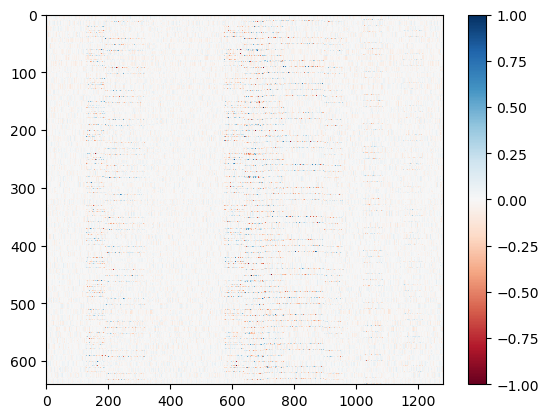

In [19]:
# plt.pcolor(x[0,3,9, :, :]-y[0,3,9, :, :], cmap='RdBu',vmin=-.005,vmax=.005)
# plt.colorbar()
# plt.gca().invert_yaxis()
# plt.show()

plt.pcolor(x[0,3,2, :, :]-pre1[0,3,2, :, :], cmap='RdBu',vmin=-1,vmax=1)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [21]:
batch = next(dl)
x = batch["x"].to(device)
y1 = batch["y1"].to(device)
x_surf = batch["x_surf"].to(device)
y1_surf = batch["y1_surf"].to(device)

0


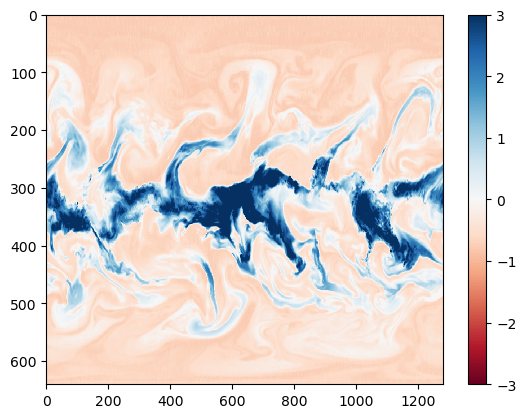

1


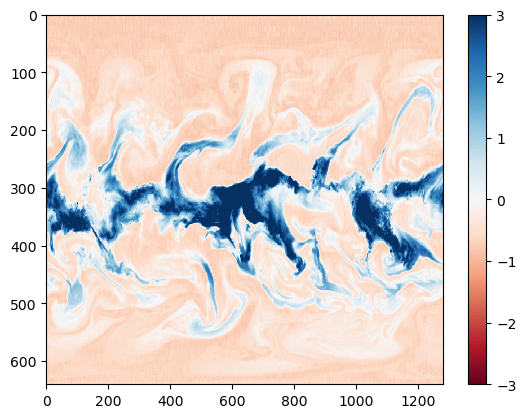

2


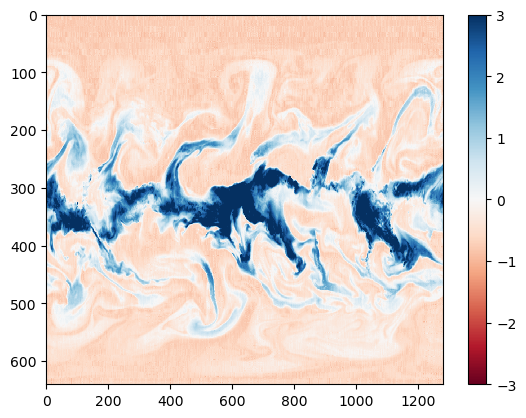

3


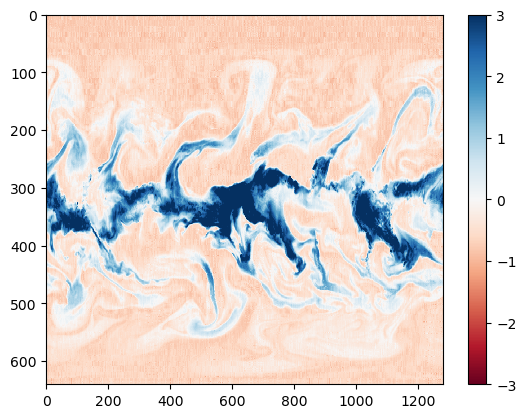

4


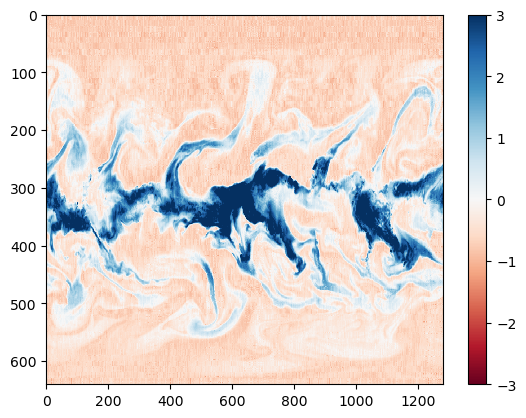

5


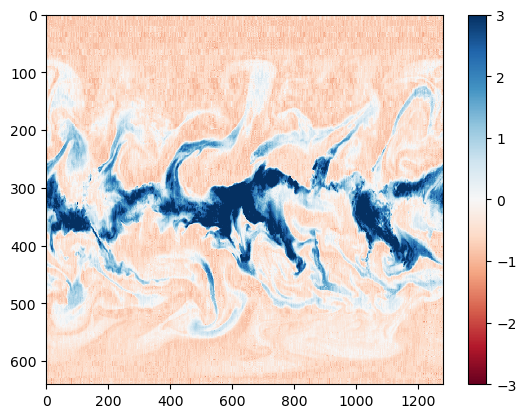

6


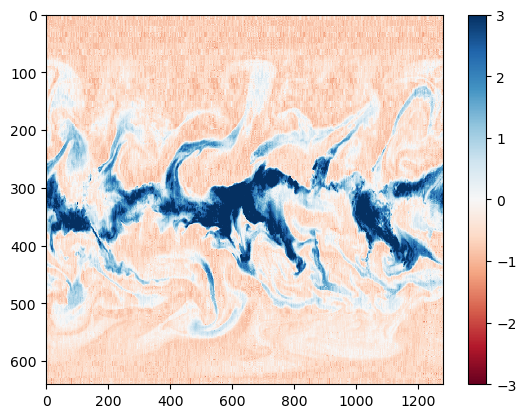

7


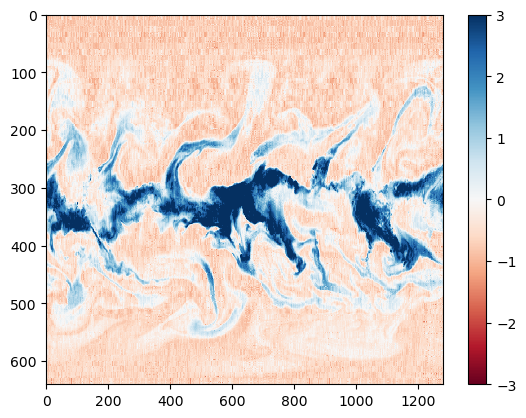

8


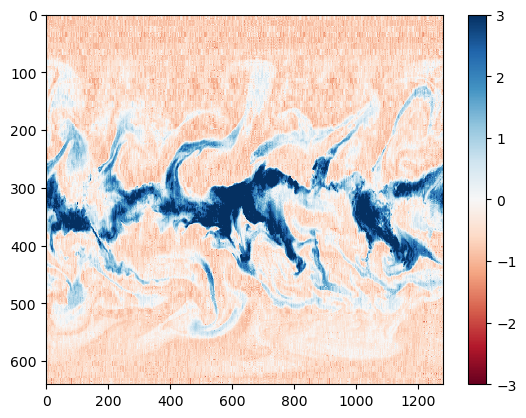

9


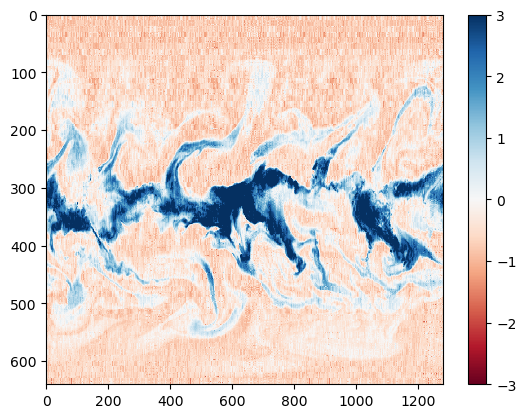

In [22]:
sv_np = np.zeros([20,4,15,640,1280])
sv_np_surf = np.zeros([20,7,640,1280])
for dd in range(10):
    print(dd)
    if dd == 0:
        y1_pred, y1_pred_surf = vae(x, x_surf)
        sv_np[dd,:,:,:,:] = y1_pred[0, :, :, :].to('cpu').detach().numpy()
        sv_np_surf[dd,:,:,:] = y1_pred_surf[0, :, :, :].to('cpu').detach().numpy()
        
    else:
        predvar1 = np.expand_dims(sv_np[dd-1,:,:,:,:],axis=0)
        predvar2 = np.expand_dims(sv_np_surf[dd-1,:,:,:],axis=0)
        y1_pred, y1_pred_surf = vae(torch.Tensor(predvar1).to(device), torch.Tensor(predvar2).to(device))
        
        
        sv_np[dd,:,:,:,:] = y1_pred[0, :, :, :].to('cpu').detach().numpy()
        sv_np_surf[dd,:,:,:] = y1_pred_surf[0, :, :, :].to('cpu').detach().numpy()

    
    
    # Optionally, if you don't need to keep the previous y1_pred values, overwrite it
    plt.pcolor(y1_pred_surf[0, 6, :, :].to('cpu').detach().numpy(), cmap='RdBu', vmin=-3, vmax=3)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()
    
    del y1_pred, y1_pred_surf
    # Explicitly release GPU memory
    torch.cuda.empty_cache()
    gc.collect()  



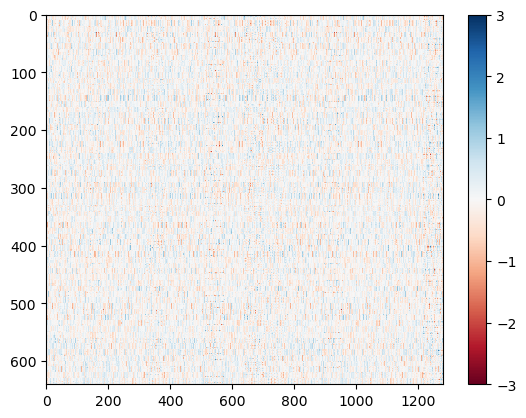

In [24]:
plt.pcolor(sv_np_surf[0, 1, :, :]-sv_np_surf[8, 1, :, :], cmap='RdBu', vmin=-3, vmax=3)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [27]:
import requests
import json

def get_random_joke():
    url = "https://official-joke-api.appspot.com/random_joke"
    response = requests.get(url)
    joke_data = json.loads(response.text)
    return joke_data['setup'], joke_data['punchline']

def tell_joke():
    setup, punchline = get_random_joke()
    print("Joke time!")
    input("Press Enter to hear the setup...")
    print(f"Setup: {setup}")
    input("Press Enter for the punchline...")
    print(f"Punchline: {punchline}")
    print("Hope you enjoyed the joke!")

if __name__ == "__main__":
    tell_joke()

Joke time!


Press Enter to hear the setup... 


Setup: What do you call a nervous javelin thrower?


Press Enter for the punchline... 


Punchline: Shakespeare.
Hope you enjoyed the joke!
